In [1]:
import pandas as pd
import numpy as np

In [2]:
# taken from imigrant conjoint data
df = pd.read_csv('/content/respondent_data.csv')

In [3]:
df.head()

,RespondentID,ProfileID,Brand,Storage,Camera,Price,Rating,Choice
0,1,1,Apple,128GB,High,High,6,0
1,1,2,Samsung,64GB,Medium,High,6,0
2,1,3,Google,256GB,Low,High,4,0
3,1,4,Samsung,256GB,High,Medium,10,0
4,1,5,Google,128GB,Medium,Medium,9,0


In [4]:
# remove empty data
clean_df = df[~df.Choice.isnull()]

In [5]:
y = clean_df['Choice']
x = clean_df[[x for x in df.columns if x != 'Rating' and x != 'Choice' and x !='RespondentID' and x !='ProfileID']]

In [6]:
xdum = pd.get_dummies(x, columns=[c for c in x.columns if c != 'selected'])
xdum.head()

,Brand_Apple,Brand_Google,Brand_Samsung,Storage_128GB,Storage_256GB,Storage_64GB,Camera_High,Camera_Low,Camera_Medium,Price_High,Price_Low,Price_Medium
0,True,False,False,True,False,False,True,False,False,True,False,False
1,False,False,True,False,False,True,False,False,True,True,False,False
2,False,True,False,False,True,False,False,True,False,True,False,False
3,False,False,True,False,True,False,True,False,False,False,False,True
4,False,True,False,True,False,False,False,False,True,False,False,True


In [7]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

In [8]:
res = sm.OLS(y, xdum, family=sm.families.Binomial()).fit()
res.summary()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:130: ValueWarning: unknown kwargs ['family']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Choice   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.437
Method:                 Least Squares   F-statistic:                     212.6
Date:                Wed, 22 Jan 2025   Prob (F-statistic):          3.91e-266
Time:                        09:57:15   Log-Likelihood:                 61.041
No. Observations:                2178   AIC:                            -104.1
Df Residuals:                    2169   BIC:                            -52.91
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Brand_Apple      -0.0241      0.007     -3.322      0.001      -0.038      -0.010
Brand_Google      0.1481      0.007     20.409      0.000       0.134       0.162
Brand_Samsung    -0.0406      0.007     -5.601      0.000      -0.055      -0.026
Storage_128GB    -0.0682      0.007     -9.397      0.000      -0.082      -0.054
Storage_256GB     0.0090      0.007      1.234      0.217      -0.005       0.023
Storage_64GB      0.1426      0.007     19.649      0.000       0.128       0.157
Camera_High       0.1756      0.007     24.206      0.000       0.161       0.190
Camera_Low       -0.0737      0.007    -10.157      0.000      -0.088      -0.059
Camera_Medium    -0.0186      0.007     -2.563      0.010      -0.033      -0.004
Price_High       -0.0833      0.007    -11.486      0.000      -0.098      -0.069
Price_Low         0.2114      0.007     29.142      0.000       0.197       0.226
Price_Medium     -0.0448      0.007     -6.170      0.000      -0.059      -0.031
==============================================================================
Omnibus:                      604.727   Durbin-Watson:                   2.511
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4365.852
Skew:                           1.112   Prob(JB):                         0.00
Kurtosis:                       9.570   Cond. No.                     3.41e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.5e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [9]:
df_res = pd.DataFrame({
    'param_name': res.params.keys()
    , 'param_w': res.params.values
    , 'pval': res.pvalues
})
# adding field for absolute of parameters
df_res['abs_param_w'] = np.abs(df_res['param_w'])
# marking field is significant under 95% confidence interval
df_res['is_sig_95'] = (df_res['pval'] < 0.05)
# constructing color naming for each param
df_res['c'] = ['blue' if x else 'red' for x in df_res['is_sig_95']]

# make it sorted by abs of parameter value
df_res = df_res.sort_values(by='abs_param_w', ascending=True)

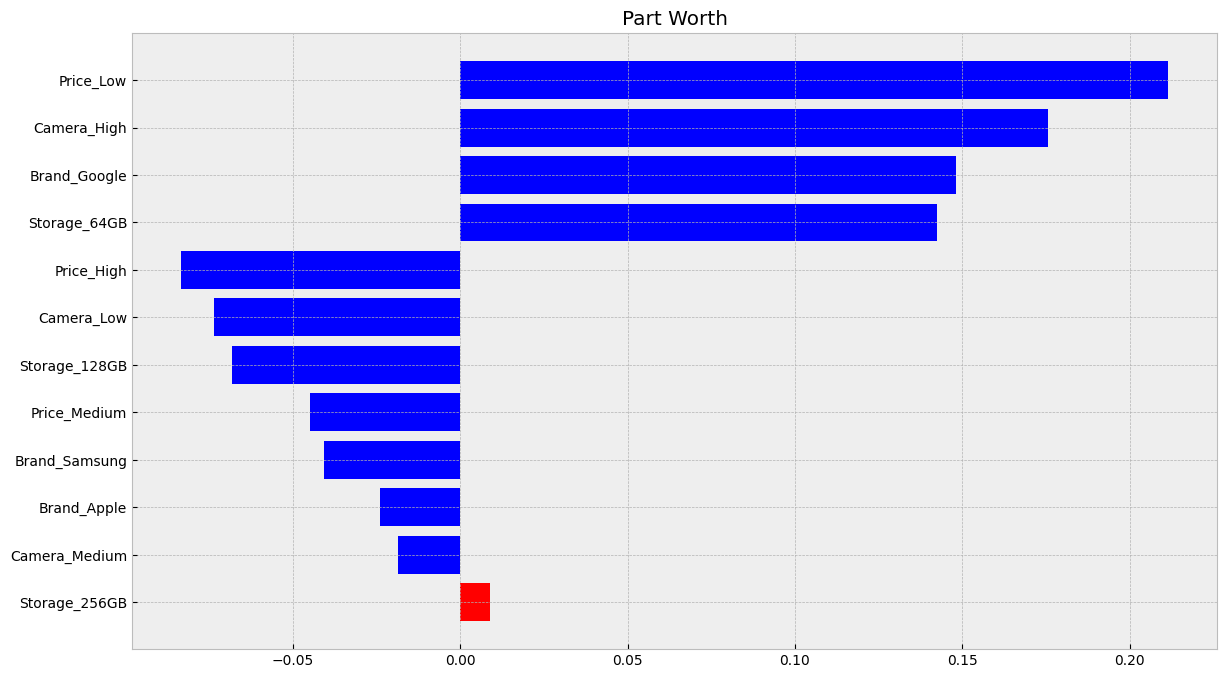

In [10]:
f, ax = plt.subplots(figsize=(14, 8))
plt.title('Part Worth')
pwu = df_res['param_w']
xbar = np.arange(len(pwu))
plt.barh(xbar, pwu, color=df_res['c'])
plt.yticks(xbar, labels=df_res['param_name'])
plt.show()

In [11]:
# need to assemble per attribute for every level of that attribute in dicionary
range_per_feature = dict()
for key, coeff in res.params.items():
    sk =  key.split('_')
    feature = sk[0]
    if len(sk) == 1:
        feature = key
    if feature not in range_per_feature:
        range_per_feature[feature] = list()

    range_per_feature[feature].append(coeff)

In [12]:
# importance per feature is range of coef in a feature
# while range is simply max(x) - min(x)
importance_per_feature = {
    k: max(v) - min(v) for k, v in range_per_feature.items()
}

# compute relative importance per feature
# or normalized feature importance by dividing
# sum of importance for all features
total_feature_importance = sum(importance_per_feature.values())
relative_importance_per_feature = {
    k: 100 * round(v/total_feature_importance, 3) for k, v in importance_per_feature.items()
}

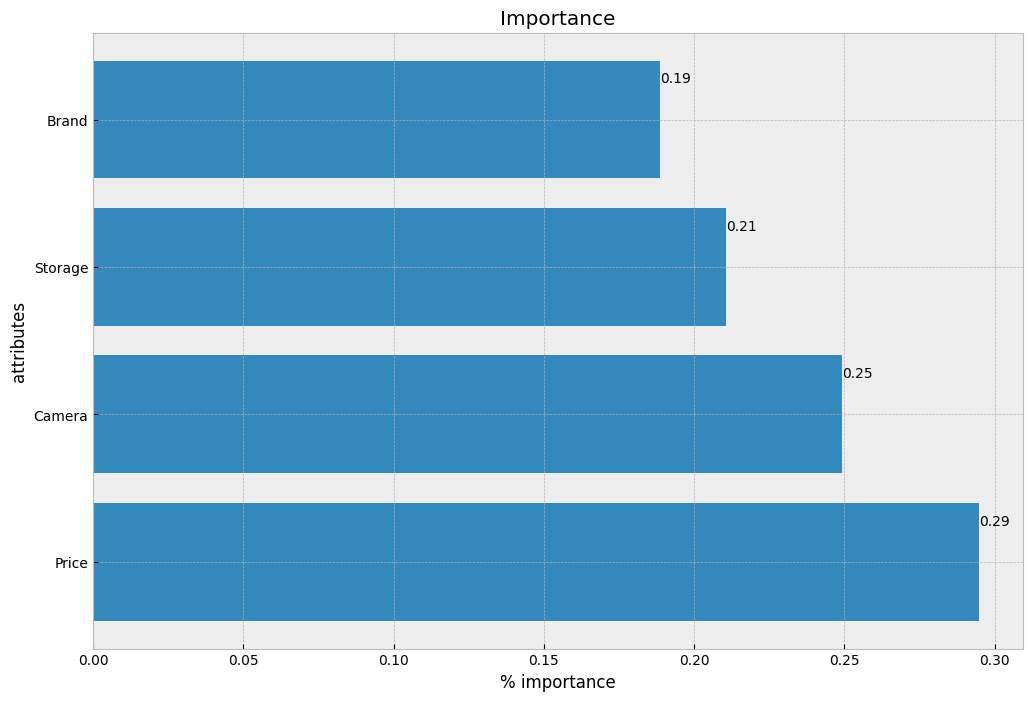

In [13]:
alt_data = pd.DataFrame(
    list(importance_per_feature.items()),
    columns=['attr', 'importance']
).sort_values(by='importance', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Importance')
plt.barh(xbar, alt_data['importance'])
for i, v in enumerate(alt_data['importance']):
    ax.text(v , i + .25, '{:.2f}'.format(v))
plt.ylabel('attributes')
plt.xlabel('% importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()

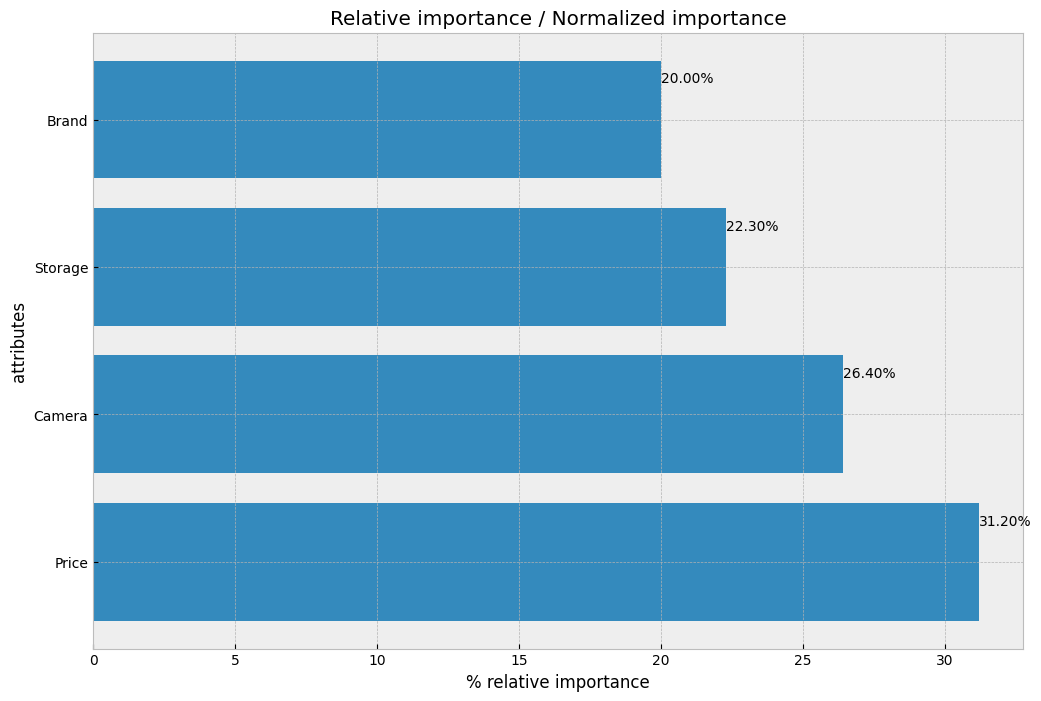

In [14]:
alt_data = pd.DataFrame(
    list(relative_importance_per_feature.items()),
    columns=['attr', 'relative_importance (pct)']
).sort_values(by='relative_importance (pct)', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Relative importance / Normalized importance')
plt.barh(xbar, alt_data['relative_importance (pct)'])
for i, v in enumerate(alt_data['relative_importance (pct)']):
    ax.text(v , i + .25, '{:.2f}%'.format(v))
plt.ylabel('attributes')
plt.xlabel('% relative importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()

In [15]:
y = clean_df['Rating']
x = clean_df[[x for x in df.columns if x != 'Rating' and x != 'Choice' and x !='RespondentID' and x !='ProfileID']]
xdum = pd.get_dummies(x, columns=[c for c in x.columns if c != 'selected'])
xdum.head()

,Brand_Apple,Brand_Google,Brand_Samsung,Storage_128GB,Storage_256GB,Storage_64GB,Camera_High,Camera_Low,Camera_Medium,Price_High,Price_Low,Price_Medium
0,True,False,False,True,False,False,True,False,False,True,False,False
1,False,False,True,False,False,True,False,False,True,True,False,False
2,False,True,False,False,True,False,False,True,False,True,False,False
3,False,False,True,False,True,False,True,False,False,False,False,True
4,False,True,False,True,False,False,False,False,True,False,False,True


In [16]:
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')
res = sm.OLS(y, xdum).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Rating   R-squared:                       0.677
Model:                            OLS   Adj. R-squared:                  0.676
Method:                 Least Squares   F-statistic:                     569.4
Date:                Wed, 22 Jan 2025   Prob (F-statistic):               0.00
Time:                        10:08:08   Log-Likelihood:                -3002.9
No. Observations:                2178   AIC:                             6024.
Df Residuals:                    2169   BIC:                             6075.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Brand_Apple       1.9508      0.030     65.857      0.000       1.893       2.009
Brand_Google      1.8034      0.030     60.882      0.000       1.745       1.861
Brand_Samsung     1.8378      0.030     62.044      0.000       1.780       1.896
Storage_128GB     1.8915      0.030     63.858      0.000       1.833       1.950
Storage_256GB     1.9136      0.030     64.602      0.000       1.855       1.972
Storage_64GB      1.7868      0.030     60.324      0.000       1.729       1.845
Camera_High       2.8006      0.030     94.548      0.000       2.743       2.859
Camera_Low        0.8681      0.030     29.307      0.000       0.810       0.926
Camera_Medium     1.9232      0.030     64.927      0.000       1.865       1.981
Price_High        0.4315      0.030     14.566      0.000       0.373       0.490
Price_Low         3.2290      0.030    109.010      0.000       3.171       3.287
Price_Medium      1.9315      0.030     65.206      0.000       1.873       1.990
==============================================================================
Omnibus:                        0.731   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.694   Jarque-Bera (JB):                0.782
Skew:                          -0.040   Prob(JB):                        0.676
Kurtosis:                       2.952   Cond. No.                     3.41e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.5e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

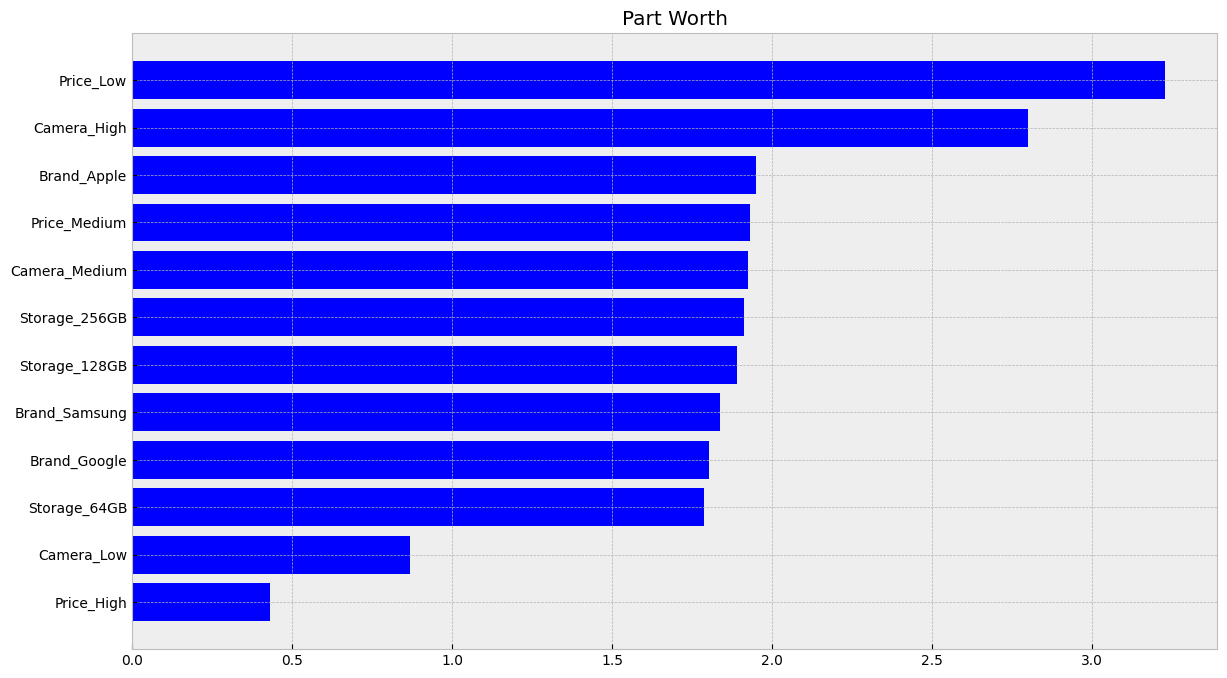

In [17]:
df_res = pd.DataFrame({
    'param_name': res.params.keys()
    , 'param_w': res.params.values
    , 'pval': res.pvalues
})
# adding field for absolute of parameters
df_res['abs_param_w'] = np.abs(df_res['param_w'])
# marking field is significant under 95% confidence interval
df_res['is_sig_95'] = (df_res['pval'] < 0.05)
# constructing color naming for each param
df_res['c'] = ['blue' if x else 'red' for x in df_res['is_sig_95']]

# make it sorted by abs of parameter value
df_res = df_res.sort_values(by='abs_param_w', ascending=True)
f, ax = plt.subplots(figsize=(14, 8))
plt.title('Part Worth')
pwu = df_res['param_w']
xbar = np.arange(len(pwu))
plt.barh(xbar, pwu, color=df_res['c'])
plt.yticks(xbar, labels=df_res['param_name'])
plt.show()

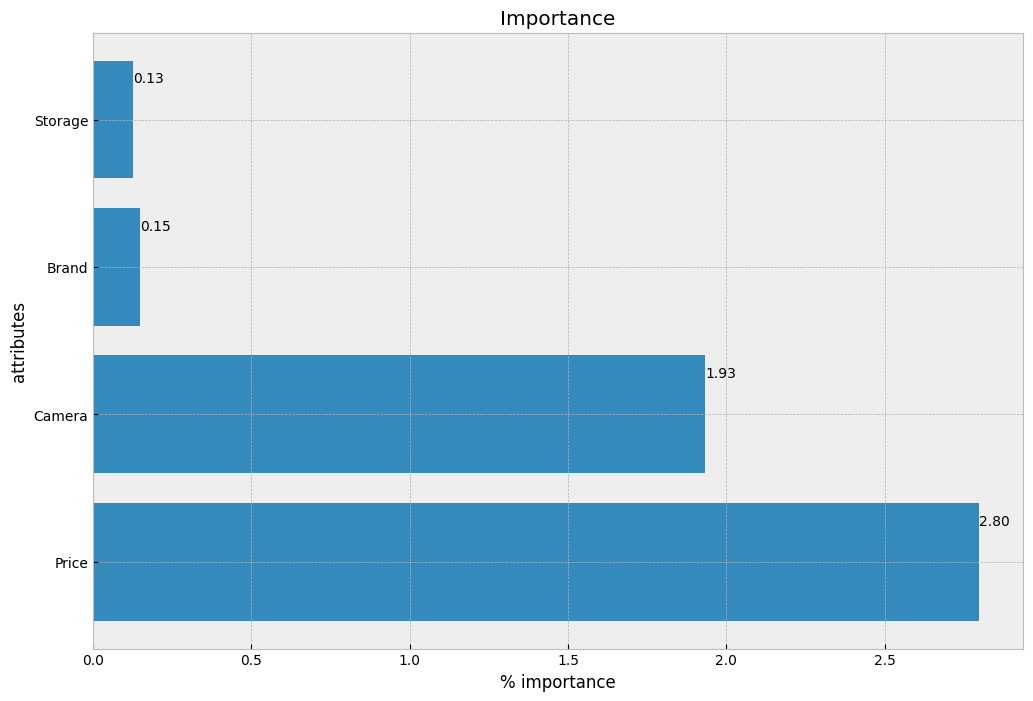

In [18]:
# need to assemble per attribute for every level of that attribute in dicionary
range_per_feature = dict()
for key, coeff in res.params.items():
    sk =  key.split('_')
    feature = sk[0]
    if len(sk) == 1:
        feature = key
    if feature not in range_per_feature:
        range_per_feature[feature] = list()

    range_per_feature[feature].append(coeff)
# importance per feature is range of coef in a feature
# while range is simply max(x) - min(x)
importance_per_feature = {
    k: max(v) - min(v) for k, v in range_per_feature.items()
}

# compute relative importance per feature
# or normalized feature importance by dividing
# sum of importance for all features
total_feature_importance = sum(importance_per_feature.values())
relative_importance_per_feature = {
    k: 100 * round(v/total_feature_importance, 3) for k, v in importance_per_feature.items()
}
alt_data = pd.DataFrame(
    list(importance_per_feature.items()),
    columns=['attr', 'importance']
).sort_values(by='importance', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Importance')
plt.barh(xbar, alt_data['importance'])
for i, v in enumerate(alt_data['importance']):
    ax.text(v , i + .25, '{:.2f}'.format(v))
plt.ylabel('attributes')
plt.xlabel('% importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()

so conjoint analysis is better than rating based analysis

In [ ]:
alt_data = pd.DataFrame(
    list(relative_importance_per_feature.items()),
    columns=['attr', 'relative_importance (pct)']
).sort_values(by='relative_importance (pct)', ascending=False)


f, ax = plt.subplots(figsize=(12, 8))
xbar = np.arange(len(alt_data['attr']))
plt.title('Relative importance / Normalized importance')
plt.barh(xbar, alt_data['relative_importance (pct)'])
for i, v in enumerate(alt_data['relative_importance (pct)']):
    ax.text(v , i + .25, '{:.2f}%'.format(v))
plt.ylabel('attributes')
plt.xlabel('% relative importance')
plt.yticks(xbar, alt_data['attr'])
plt.show()